In [2]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline

In [4]:
import pandas as pd

In [5]:
from astropy.wcs        import WCS
from astropy.io         import fits
from astropy.io.ascii   import read as asciiRead
from astropy.modeling   import models, fitting
from astropy.stats      import sigma_clipped_stats
from astropy.table      import Table
                      
from matplotlib         import rcParams
from matplotlib.colors  import LogNorm
from matplotlib         import style

from photutils  import DAOStarFinder
from photutils  import find_peaks
from pylab      import *

from reproject  import reproject_exact

# from seaborn                  import *
from statsmodels.robust.scale import mad

from time import time
from tqdm import tqdm_notebook

In [6]:
# style.use('default')
# style.use('fivethirtyeight')

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"]  = 100
rcParams["axes.grid"]   = False

In [7]:
y,x = 0,1

**Load Fits Files and Comet Data**

In [8]:
comet_dat = asciiRead('comet74p.dat')
yc,xc,zc  = comet_dat['Y_PIXEL'].data[0], comet_dat['X_PIXEL'].data[0], 0.0

yc_0, xc_0= np.copy(yc), np.copy(xc)

In [9]:
ref_image_name  = 'asm_new_local_PTF_d100124_f02_c00_u000098496_p12_refimg.fits'
refproj_im_name = 'asm_reproj_loc_PTF_d100124_f02_c00_u000098496_p12_refimg.fits'
# ref_image_name  = 'PTF_d100124_f02_c00_u000098496_p12_refimg.fits'
sci_image_name  = 'PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.fits'

In [10]:
ref_frame_0  = fits.open(ref_image_name)
sci_frame    = fits.open(sci_image_name)

In [11]:
sci_frame[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / FOUR-BYTE SINGLE PRECISION FLOATING POINT      
NAXIS   =                    2 / STANDARD FITS FORMAT                           
NAXIS1  =                 2048 / STANDARD FITS FORMAT                           
NAXIS2  =                 4096 / STANDARD FITS FORMAT                           
ORIGIN  = 'Palomar Transient Factory' / Origin of these image data              
CREATOR = 'Infrared Processing and Analysis Center' / Creator of this FITS file 
TELESCOP= 'P48     '           / Name of telescope                              
INSTRUME= 'PTF/MOSAIC'         / Instrument name                                
OBSERVER= 'KulkarniPTF'        / Observer name and project                      
CCDID   = '0       '           / CCD number (0..11)                             
DATE-OBS= '2010-02-17T08:31:47.904' / UTC shutter time YYYY-MM-DDTHH:MM:SS.SSS  
DATE    = '2011-06-18T04:20:

In [12]:
print(comet_dat.colnames)

['comet name', 'mag', 'magerr', 'FWHM', 'FWHMerr', 'X_PIXEL', 'Y_PIXEL', 'R.A.(deg)', 'Dec.(deg)']


**Reproject Reference Frame to Science Frame Header**

In [13]:
ref_frame  = reproject_exact(ref_frame_0['PRIMARY'], sci_frame['PRIMARY'].header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


**DAO Find**

**Compute Basic Stats**

In [14]:
sigma = 3.0
iters = 5

In [15]:
sci_mean, sci_median, sci_std = sigma_clipped_stats(sci_frame[0].data, sigma=sigma, iters=iters)
ref_mean, ref_median, ref_std = sigma_clipped_stats(ref_frame[0].data, sigma=sigma, iters=iters)
# rep_mean, rep_median, rep_std = sigma_clipped_stats(reproj_frame[0], sigma=sigma, iters=iters)

/Users/jonathan/anaconda3/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:158: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/jonathan/anaconda3/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:159: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


In [16]:
print(sci_mean, sci_median, sci_std)

1331.3609692212356 1331.2593994140625 30.456614232766515


In [17]:
print(ref_mean, ref_median, ref_std)

334.78510594023186 334.69724673816035 2.9233451775308126


In [18]:
nSig  = 5.0
fwhm  = 3.0
sci_daofind = DAOStarFinder(fwhm=fwhm, threshold=nSig*sci_std)
ref_daofind = DAOStarFinder(fwhm=fwhm, threshold=nSig*ref_std)
# rep_daofind = DAOStarFinder(fwhm=fwhm, threshold=nSig*rep_std)

In [19]:
sci_dao_sources = sci_daofind(sci_frame[0].data - sci_median)
ref_dao_sources = ref_daofind(ref_frame[0].data - ref_median)
# rep_dao_sources = rep_daofind(reproj_frame[0] - rep_median)

/Users/jonathan/anaconda3/lib/python3.6/site-packages/photutils/detection/findstars.py:399: RuntimeWarning: invalid value encountered in greater
  object_labels, nobjects = ndimage.label(convolved_data > threshold,
/Users/jonathan/anaconda3/lib/python3.6/site-packages/photutils/detection/core.py:241: RuntimeWarning: invalid value encountered in greater
  peak_goodmask = np.logical_and(peak_goodmask, (data > threshold))
/Users/jonathan/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/jonathan/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [20]:
print(sci_dao_sources)

 id      xcentroid      ...        flux                mag         
---- ------------------ ... ------------------ --------------------
   1  84.32507514094027 ... 2.8466888554343353   -1.135850002823066
   2  92.75768962912889 ... 2.5581158735482266   -1.019800531457882
   3  475.3325185950535 ...  2.599996865809087   -1.037432061116815
   4   84.1194641244433 ... 1.7620634604627974  -0.6150538635279158
   5 1919.4748513990276 ... 202.29480547752073   -5.764961827769661
   6  941.8143158177106 ... 1.3772107238896443  -0.3475009893873632
   7 1855.7899692143321 ... 2.7548552670895874  -1.1002469677195308
   8 277.36248923391116 ... 2.4215131644337857   -0.960217086022377
   9  859.4731067430565 ... 1.0997436158709828 -0.10322862382604428
  10 1185.9151290786515 ...  147.4290087989446   -5.421457364197196
 ...                ... ...                ...                  ...
1929 406.75785530958314 ...  152.6695391563676   -5.459380986617019
1930 1445.5317620727874 ... 1.8144660016316294  

In [21]:
print(ref_dao_sources)

 id      xcentroid      ...        flux                mag         
---- ------------------ ... ------------------ --------------------
   1  220.7595000360656 ... 30.352762653670723   -3.705495564775382
   2  720.2619438527964 ... 3.7334341122918735  -1.4302712282389243
   3 1346.4715070144393 ...  2.938666618973286  -1.1703757993490553
   4 1972.9687128154114 ... 1.8392188459025736  -0.6615835209107245
   5  745.6896527323488 ... 1.0996150402532356  -0.1031016784522122
   6  961.5639097988645 ... 1.7305239464508015  -0.5954440332583903
   7 1104.0868212428304 ...  2.460551528748772  -0.9775811610973919
   8  984.1161614687543 ... 1.2024910013997732 -0.20020458775595024
   9 1872.6339545903131 ... 2.4133102952840586  -0.9565329140402958
  10  413.5889369340608 ... 2.3936578850046515  -0.9476551967632841
 ...                ... ...                ...                  ...
7739 1448.0587117243986 ... 1.0837563910906922 -0.08732917899552681
7740 206.20466948788524 ... 1.1997073046177638  

In [22]:
comet_loc = argmin((sci_dao_sources['xcentroid'] - xc_0)**2. + (sci_dao_sources['ycentroid'] - yc_0)**2.)

yc_1 = sci_dao_sources['ycentroid'][comet_loc]
xc_1 = sci_dao_sources['xcentroid'][comet_loc]

print(yc_0, yc_1, xc_0, xc_1)

3782.1 3782.627269795958 911.9 915.0168571675272


**Plot Star Fields and Sources Found**

In [23]:
sci_dao_sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,84.32507514094027,3.1825509226889195,0.4864689329141776,-0.2451601520992479,-0.369405793995,25.0,0.0,-11.6859130859375,2.8466888554343353,-1.135850002823066
2,92.75768962912889,2.8806718235871625,0.32610058689566884,-0.00027637211932749823,-0.6566265997049398,25.0,0.0,33.9228515625,2.5581158735482266,-1.019800531457882
3,475.3325185950535,3.6905170204921274,0.4549847838401045,0.06085994268828331,-0.044902149348745306,25.0,0.0,550.307861328125,2.599996865809087,-1.037432061116815
4,84.1194641244433,7.498132155430158,0.5269801604931091,-0.3414464273188047,0.7200346843088716,25.0,0.0,-17.876953125,1.7620634604627974,-0.6150538635279158
5,1919.4748513990276,7.429832613579318,0.48788305170894464,-0.23501221216319212,-0.20570943838783703,25.0,0.0,55309.53515625,202.29480547752073,-5.764961827769661
6,941.8143158177106,7.619219359867156,0.473528043423239,-0.02491072390962154,-0.10017738754981538,25.0,0.0,292.8631591796875,1.3772107238896443,-0.3475009893873632
7,1855.7899692143321,8.093023346026436,0.4231290613652211,-0.16795451650886856,-0.4395390091151269,25.0,0.0,523.3857421875,2.7548552670895874,-1.1002469677195308
8,277.36248923391116,9.412015863971353,0.44538847423479655,0.06400556949892681,0.14454225419543926,25.0,0.0,549.3145751953125,2.4215131644337857,-0.960217086022377
9,859.4731067430565,10.697392596644905,0.5265901814827155,-0.6914115052720186,-0.24377871926345307,25.0,0.0,262.2103271484375,1.0997436158709828,-0.10322862382604428


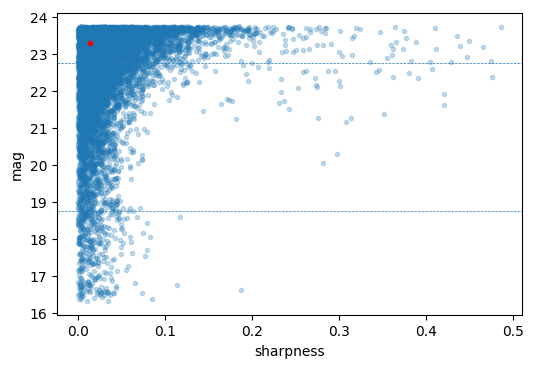

In [24]:
# zero    = 0.00
# sharpLo = 0.00
# sharpHi = 0.05
# fluxLo  = 6.50
# fluxHi  = 125.0

# use = (abs(ref_dao_sources['sharpness'].data - median(ref_dao_sources['sharpness'].data)) < 0.05)*\
#       (ref_dao_sources['flux'].data > 6.5)*(ref_dao_sources['flux'].data < 125.0)

# plot(abs(ref_dao_sources['sharpness'].data - median(ref_dao_sources['sharpness'].data))[use], \
#          ref_dao_sources['flux'].data[use],'.', alpha=0.25);

plot(abs(ref_dao_sources['sharpness'].data - median(ref_dao_sources['sharpness'].data)), \
         ref_dao_sources['mag'].data+ref_frame_0[1].header['MAGZPT'],'.', alpha=0.25);

plot(abs(ref_dao_sources['sharpness'].data - median(ref_dao_sources['sharpness'].data))[comet_loc], \
         ref_dao_sources['mag'].data[comet_loc]+ref_frame_0[1].header['MAGZPT'],'r.');

ylabel('mag');
xlabel('sharpness');

# axvline(zero    , ls='--', lw=0.5);
axhline(ref_frame_0[1].header['MAGZPT']-1.0    , ls='--', lw=0.5);
axhline(ref_frame_0[1].header['MAGZPT']-5.0    , ls='--', lw=0.5);
# axvline(sharpLo , ls='--', lw=1.0);
# axvline(sharpHi , ls='--', lw=1.0);
# axhline(fluxLo  , ls='--', lw=0.5);
# axhline(fluxHi  , ls='--', lw=0.5);

# ylim(0, 135);

In [27]:
import itertools

color_list = ['navy', 'cyan', 'cornflowerblue', 'gold', 'darkorange']
color_iter = itertools.cycle(color_list)

def plot_results(X, Y_, means, covariances, index, title, nAx=1):
    splot = plt.subplot(nAx, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v,w = linalg.eigh(covar)
        v   = 2. * np.sqrt(2.) * np.sqrt(v)
        u   = w[0] / linalg.norm(w[0])
        
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i): continue
        
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
        
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    
    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

In [101]:
from sklearn import mixture
from sklearn.preprocessing import StandardScaler
def find_print_stars(image, sources, zero_point, 
                     dist_min      = 10,
                     edge_width    = 10,
                     peak_width    =  2,
                     delta_mag_max = -2.0,
                     delta_mag_min = -5.0,
                     x_key         = 'roundness2',
                     y_key         = 'mag'):
    
    x_rng = {'sharpness':0.05, 'roundness1':0.5, 'roundness2':0.5}
    
    xaxis = sources[x_key].data
    yaxis = sources[y_key].data + zero_point
    
    X_0     = np.c_[xaxis, yaxis]
    X       = StandardScaler().fit_transform(X_0)
    
    xax_mean= xaxis.mean()
    yax_mean= yaxis.mean()
    xax_std = xaxis.std()
    yax_std = yaxis.std()
    
    mag_min = zero_point + delta_mag_min
    mag_max = zero_point + delta_mag_max
    
    dpgmm   = mixture.BayesianGaussianMixture(n_components=5, covariance_type='full').fit(X)
    
    Y_  = dpgmm.predict(X)
    
    keep_ind  = []
    for i, (mean, covar, color) in enumerate(zip(dpgmm.means_, dpgmm.covariances_, color_iter)):
        condition1  = X_0[Y_ == i, 1].mean() > mag_min
        condition2  = X_0[Y_ == i, 1].mean() < mag_max
        condition3  = abs(median(X_0[Y_ == i, 0]) - median(X_0[:, 0])) < x_rng[x_key]
        if condition1 and condition2 and condition3:
            keep_ind  = keep_ind + list(np.arange(xaxis.size)[Y_ == i])
    
    mag_match = (yaxis[keep_ind] > mag_min)*(yaxis[keep_ind] < mag_max)
    keep_ind  = np.array(keep_ind)[mag_match]
    
    y_ctrs, x_ctrs = sources['ycentroid'][keep_ind], sources['xcentroid'][keep_ind]
    yshape, xshape = sci_frame[0].shape
    
    keep_ind_out  = []
    for k, k_ind in enumerate(keep_ind):
        ycNow, xcNow  = y_ctrs[k], x_ctrs[k]
        
        yupper  = int(np.round(ycNow + edge_width))
        ylower  = int(np.round(ycNow - edge_width))
        xupper  = int(np.round(xcNow + edge_width))
        xlower  = int(np.round(xcNow - edge_width))
        
        y_midpoint = np.int(np.round(0.5*(yupper-ylower)))
        x_midpoint = np.int(np.round(0.5*(xupper-xlower)))
        
        if ylower > edge_width and xlower > edge_width and yupper < yshape-edge_width and xupper < xshape-edge_width:
            subframe = image[ylower:yupper, xlower:xupper]
            if subframe.max() == subframe[edge_width-peak_width:edge_width+peak_width, \
                                          edge_width-peak_width:edge_width+peak_width].max():
                
                xy_dist_map = ((y_ctrs - ycNow)**2 + (x_ctrs - xcNow)**2)
                xy_closest  = xy_dist_map.argsort()[1]
                clst_dist_xy= xy_dist_map[xy_closest]
                if clst_dist_xy > dist_min:
                    keep_ind_out.append(k_ind)
    
    return np.array(keep_ind_out)


In [102]:
sci_zero_point = sci_frame[0].header['MAGZPT']
ref_zero_point = ref_frame_0[1].header['MAGZPT']

In [115]:
ref_keep_ind_out  = find_print_stars(ref_frame[0], ref_dao_sources, ref_zero_point, 
                                     dist_min      = 10,
                                     edge_width    = 10,
                                     peak_width    =  2,
                                     delta_mag_max = -2.0,
                                     delta_mag_min = -5.0,
                                     x_key         = 'roundness2',
                                     y_key         = 'mag')
len(ref_keep_ind_out)

/Users/jonathan/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/jonathan/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


1325

In [116]:
sci_keep_ind_out  = find_print_stars(sci_frame[0].data, sci_dao_sources, sci_zero_point, 
                                     dist_min      = 10,
                                     edge_width    = 10,
                                     peak_width    =  2,
                                     delta_mag_max = -2.0,
                                     delta_mag_min = -5.0,
                                     x_key         = 'roundness2',
                                     y_key         = 'mag')
len(sci_keep_ind_out)

/Users/jonathan/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


446

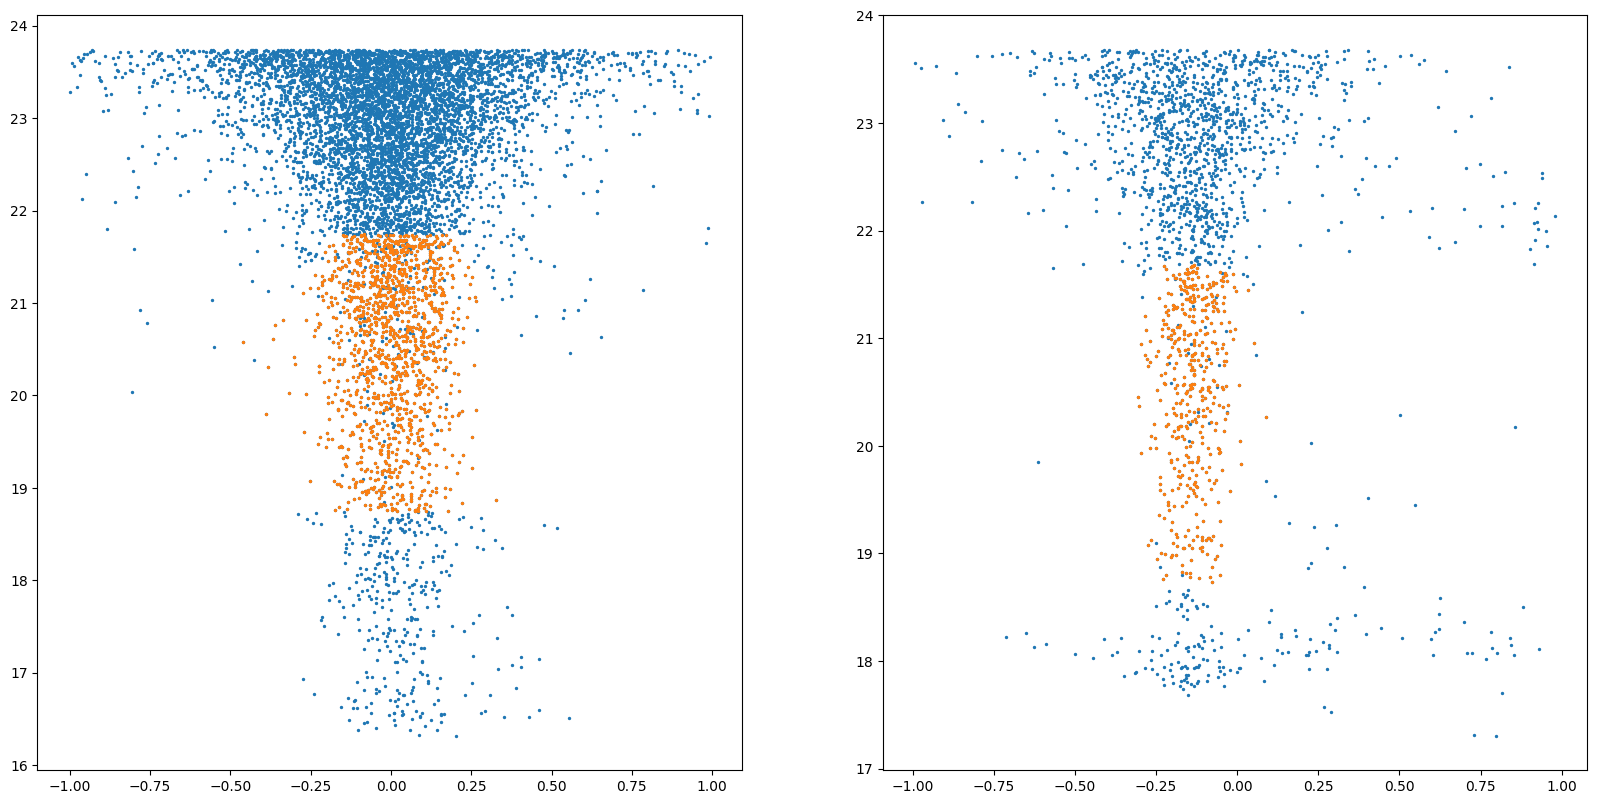

In [117]:
fig = figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xaxis = ref_dao_sources[x_key].data
yaxis = ref_dao_sources[y_key].data + ref_zero_point

ax1.scatter(xaxis,yaxis,s=2);
ax1.scatter(xaxis[ref_keep_ind_out], yaxis[ref_keep_ind_out],s=2);

xaxis = sci_dao_sources[x_key].data
yaxis = sci_dao_sources[y_key].data + sci_zero_point

ax2.scatter(xaxis,yaxis,s=2);
ax2.scatter(xaxis[sci_keep_ind_out],yaxis[sci_keep_ind_out],s=2);

In [118]:
yc_choice, xc_choice  = yc_0, xc_0#y_round1_min, x_round1_min

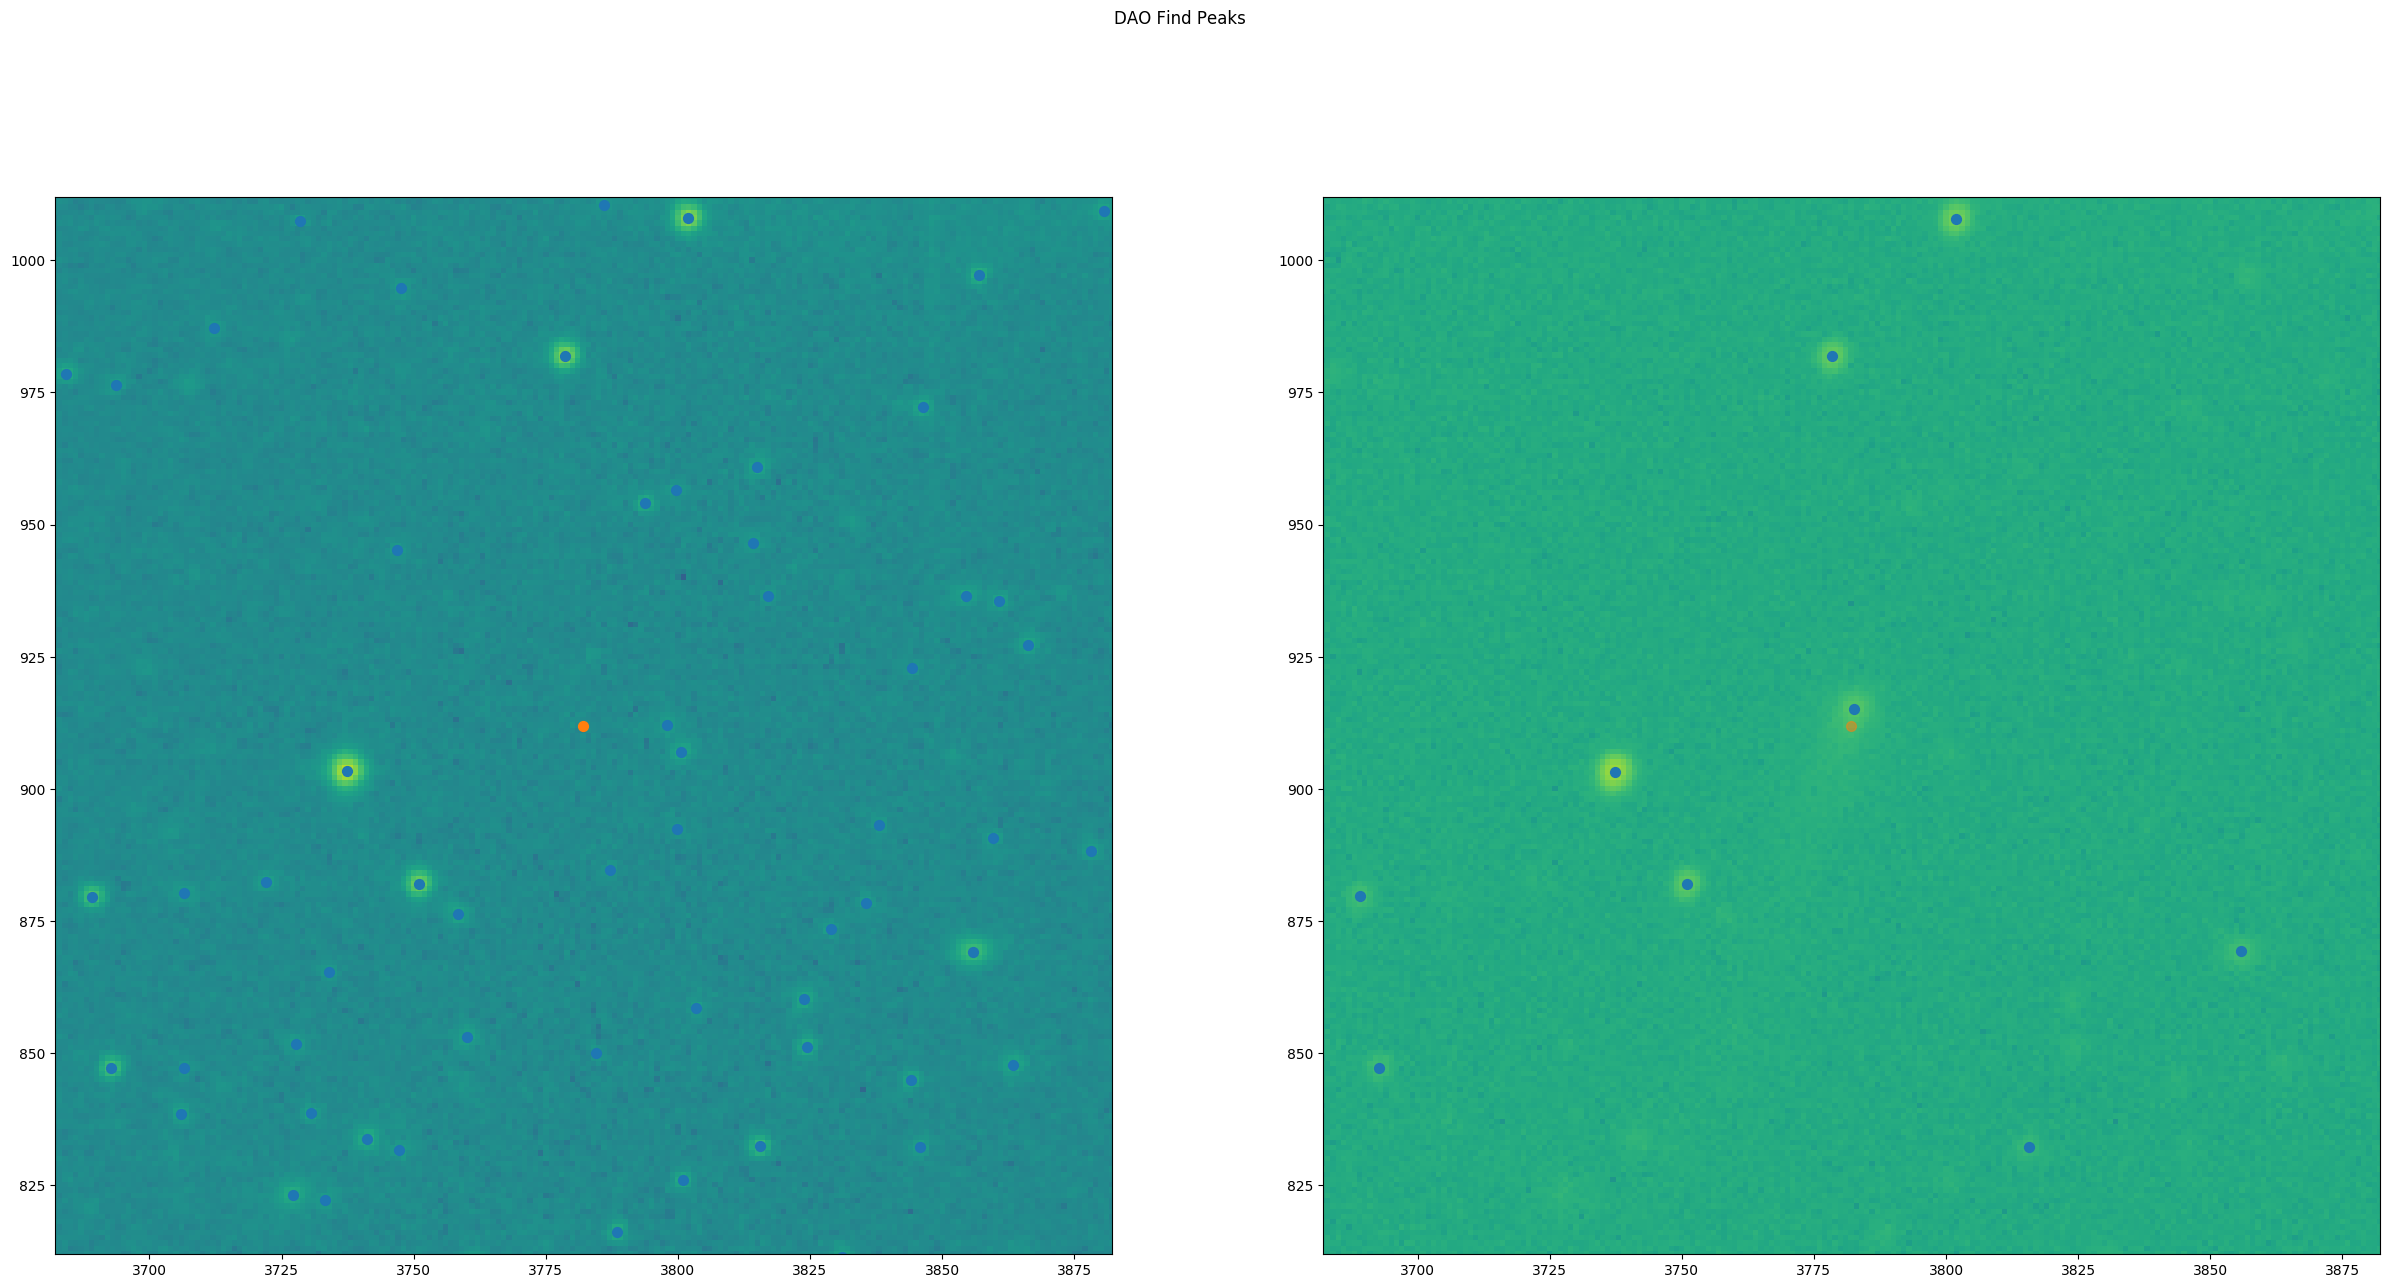

In [119]:
fig = figure(figsize=(30,15));
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(ref_frame[0].T - ref_median + 5*ref_std, norm=LogNorm());
ax1.scatter(ref_dao_sources['ycentroid'] , ref_dao_sources['xcentroid'], s=50);#, alpha=0.5);
ax1.scatter(yc_choice, xc_choice, s=50)
ax1.set_xlim(yc_choice-100, yc_choice+100);
ax1.set_ylim(xc_choice-100, xc_choice+100);

ax2.imshow(sci_frame[0].data.T - sci_median + 5*sci_std, norm=LogNorm());
ax2.scatter(sci_dao_sources['ycentroid'] , sci_dao_sources['xcentroid'], s=50);#, alpha=0.5);
ax2.scatter(yc_choice, xc_choice, s=50, alpha=0.5);
ax2.set_xlim(yc_choice-100, yc_choice+100);
ax2.set_ylim(xc_choice-100, xc_choice+100);

fig.suptitle('DAO Find Peaks');

**End Peak Finder**

**Save Reprojected Reference Frame and Peak Centroids**

In [122]:
refproj_im_name

'asm_reproj_loc_PTF_d100124_f02_c00_u000098496_p12_refimg.fits'

In [120]:
fits.writeto(refproj_im_name, ref_frame[0], header=sci_frame[0].header, overwrite=True)

In [123]:
ref_XY = np.transpose([ref_dao_sources['xcentroid'].data[ref_keep_ind_out], 
                       ref_dao_sources['ycentroid'].data[ref_keep_ind_out]])
sci_XY = np.transpose([sci_dao_sources['xcentroid'].data[sci_keep_ind_out], 
                       sci_dao_sources['ycentroid'].data[sci_keep_ind_out]])

np.savetxt(ref_image_name.replace('.fits', '.substamps.dat'), ref_XY, fmt='%.5f')
np.savetxt(sci_image_name.replace('.fits', '.substamps.dat'), sci_XY, fmt='%.5f')

**Ready for HOTPANTS**

In [ ]:
hotpants -inim PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.fits \
         -tmplim asm_reproj_loc_PTF_d100124_f02_c00_u000098496_p12_refimg.fits   \
         -outim PTF_u011673859_minus_u000098496_refimg_default.fits \
         -ssf   PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.substamps.dat \
         -nss 1 \
         -afssc 25

In [ ]:
hotpants -inim asm_reproj_loc_PTF_d100124_f02_c00_u000098496_p12_refimg.fits   \
         -tmplim PTF_201002173554_i_p_scie_t083147_u011673859_f02_p100124_c00.fits \
         -outim PTF_u000098496_refimg_minus_u011673859.fits \
         -ssf   asm_new_local_PTF_d100124_f02_c00_u000098496_p12_refimg.substamps.dat \
         -nss 1 \
         -afssc 25

In [ ]:
colormaps = {}
for key in plt.cm.__dict__.keys():
    if type(plt.cm.__dict__[key]) == matplotlib.colors.LinearSegmentedColormap: 
        colormaps[key] = plt.cm.__dict__[key]

In [ ]:
plot_data = (sci_frame[0].data - median(sci_frame[0].data))[int(yc-100):int(yc+101),int(xc-100):int(xc+101)]

In [ ]:
colors_i_like = ['cubehelix', 'BrBG', 'PiYG', 'PRGn', 'RdGy', 'RdYlBu', \
                 'Spectral', 'gist_ncar', 'gist_rainbow', 'coolwarm', 'jet', \
                 'jet_r', 'rainbow_r', 'terrain_r', 'nipy_spectral_r', 'spectral_r',\
                 'BrBG_r', 'PiYG_r', 'RdBu_r', 'RdGy_r', 'RdYlBu_r', 'RdYlGn_r', \
                 'Spectral_r', 'spectral_r', 'gist_earth_r', 'gist_rainbow_r']

In [ ]:
for colorname in colors_i_like:
    if colorname not in colormaps.keys():
        print(colorname + ' is missing')

In [ ]:
chosen_colormap = colormaps['BrBG']

In [ ]:
imshow(sci_frame[0].data - median(sci_frame[0].data), norm=LogNorm(), cmap=chosen_colormap);
# colorbar()
plt.scatter(xc,yc,s=2,c='r');
plt.ylim(yc-100, yc+100)
plt.xlim(xc-100, xc+100)

In [ ]:
sciWCS      = WCS(sci_frame[0].header)
refWCS      = WCS(ref_frame[0].header)

In [ ]:
y, x        = 0,1

In [ ]:
sciWCS      = WCS(sci_frame[0].header)
refWCS      = WCS(ref_frame[0].header)

refdata     = ref_frame[0].data.copy()
refdata[where(isnan(refdata))]  = median(refdata[where(~isnan(refdata))])

scidata     = sci_frame[0].data.copy()
scidata[where(isnan(scidata))]  = median(scidata[where(~isnan(scidata))])

In [ ]:
useRef  = ~isnan(ref_frame[0].data)
useSci  = ~isnan(sci_frame[0].data)

med_refdata = median(refdata[useRef])
mad_refdata = mad(refdata[useRef].ravel())

med_scidata = median(scidata[useSci])
mad_scidata = mad(scidata[useSci].ravel())

refWCS      = WCS(ref_frame[0].header)   # tested: same as calling WCS(filename)
sciWCS      = WCS(sci_frame[0].header)   # tested: same as calling WCS(filename)

ref_SubSkybg    = refSubData - med_refdata
sci_SubSkybg    = sciSubData - med_scidata

In [ ]:
yc,xc,zc    = comet74p['Y_PIXEL'].data[0], comet74p['X_PIXEL'].data[0], 0.0

In [ ]:
Yrange      = 50
Xrange      = 50

# offset       = 500
# yc_0, xc_0     = yc, xc
# del yc, xc
# yc, xc         = yc_0 - offset, xc_0+offset

sciSubframe    = [  [int(round(yc-Yrange)), int(round(yc+Yrange))] ,
                    [int(round(xc-Xrange)), int(round(xc+Xrange))]]

cometRA, cometDEC            = array(sciWCS.all_pix2world(xc,yc,zc))
refPixCometX, refPixCometY   = array(refWCS.all_world2pix(cometRA, cometDEC, 0.0))

refSubframe    = [  [int(round(refPixCometY - Yrange))+1,int(round(refPixCometY + Yrange))+1] ,
                    [int(round(refPixCometX - Xrange))+1,int(round(refPixCometX + Xrange))+1]]

sciSubData  = scidata[sciSubframe[y][0]:sciSubframe[y][1],sciSubframe[x][0]:sciSubframe[x][1]]
refSubData  = rot90(refdata[refSubframe[y][0]:refSubframe[y][1],refSubframe[x][0]:refSubframe[x][1]],2)

showSciAndRefData   = True
if showSciAndRefData:
    fig = gcf()
    ax1 = fig.add_axes([0.05, 0.05, 0.40, 0.80])#, projection=refWCS)
    ax2 = fig.add_axes([0.55, 0.05, 0.40, 0.80])#, projection=refWCS)
    ax1.imshow(sciSubData - med_scidata)
    ax2.imshow(refSubData - med_refdata)
    fig.canvas.draw()

In [ ]:
def gaussian1D(center, width, height = None, offset = None):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """    
    """
        Written by Nate Lust
        Edited  by Jonathan Fraine

        Returns a 1D gaussian function with the given parameters

        center  = center of gaussian profile

        width   = width  of gaussian profile

        height  = height of gaussian profile
                    -- defaults to `1 / np.sqrt(2.*pi*sigma**2.)`

        offset  = background, lower limit value for gaussian
                    -- defaults to 0.0
    """

    if height == None:
        height  = np.sqrt(2.*np.pi*width**2.)
        height  = 1.0/height

    if offset == None:
        offset = 0.0

    width   = float(width)

    return lambda x: height*np.exp(-(((center - x)/width)**2)/2) + offset

def gaussian2D(center_y, center_x, width_y, width_x = None, height = None, offset = None):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """    
    """
        Written by Nate Lust
        Edited  by Jonathan Fraine

        Returns a 2D gaussian function with the given parameters

        center_y, center_x  = center position of 2D gaussian profile

        width_y , width_x   = widths of 2D gaussian profile (if width_y != width_x, then gaussian crossection = ellipse)

        height  = height of gaussian profile
                    -- defaults to `1 / np.sqrt(2.*pi*sigma**2.)`

        offset  = background, lower limit value for gaussian
                    -- defaults to 0.0
    """

    if width_x == None:
        width_x = width_y

    if height == None:
        height = np.sqrt(2*np.pi*(width_x**2 + width_y**2))
        height = 1./height

    if offset == None:
        offset = 0.0

    width_x = float(width_x)
    width_y = float(width_y)

    return lambda y,x: height*np.exp(-(((center_x-x)/width_x)**2 + ( (center_y-y)/width_y)**2)/2)+offset

def conv1D(arr1, arr2):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """    
    '''
        Convolve 2 arrays together
            -- used by `smooth_gaussconv`
    '''
    fft1    = np.fft.fft(arr1)
    fft2    = np.fft.fft(arr2)

    conv    = np.fft.ifft(fft1*fft2)

    return np.real(np.fft.fftshift(conv))

def conv2D(arr1, arr2):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """    
    '''
        Convolve 2 arrays together
            -- used by `smooth_gaussconv`
    '''
    fft1    = np.fft.fft2(arr1)
    fft2    = np.fft.fft2(arr2)

    conv    = np.fft.ifft2(fft1*fft2)

    return np.real(np.fft.fftshift(conv))
def smooth_gaussconv(arr, sigma):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """    
    '''
        Gaussian smooths `arr` over a width of `sigma`
            -- uses `conv1D` and `conv2D`, which both use np.fft
    '''
    if len(arr.shape) == 1:
        gs1D    = gaussian1D(arr.size/2, sigma)(np.arange(arr.size))
        return conv1D(gs1D, arr) / gs1D.sum()

    if len(arr.shape) == 2:
        gs2D    = gaussian2D(arr.shape[0]/2., arr.shape[1]/2., sigma)(*np.indices(arr.shape))
        return conv2D(gs2D, arr) / gs2D.sum()


In [ ]:
from functools import partial

In [ ]:
def res_sigma_image_flat(sigma, scisub, refsub):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    med_sci = median(scisub[np.isfinite(scisub)])
    med_ref = median(refsub[np.isfinite(refsub)])
    
    #sciSub_scl = (scisub - med_sci)/(scisub.max() - med_sci)
    refSub_scl = (smooth_gaussconv(refsub,sigma) - med_ref) / (smooth_gaussconv(refsub,sigma).max() - med_ref) 
    #print(sum(((sciSub_scl-refSub_scl)**2)[:30]))
    return refSub_scl.ravel() * (scisub.max() - med_sci) + med_sci

def res_sigma_image(sigma, scisub, refsub):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    med_sci = median(scisub[np.isfinite(scisub)])
    med_ref = median(refsub[np.isfinite(refsub)])
    
    #sciSub_scl = (scisub - med_sci)/(scisub.max() - med_sci)
    refSub_scl = (smooth_gaussconv(refsub,sigma) - med_ref) / (smooth_gaussconv(refsub,sigma).max() - med_ref) 
    #print(sum(((sciSub_scl-refSub_scl)**2)[:30]))
    return refSub_scl * (scisub.max() - med_sci) + med_sci

def res_sigma(sigma, scisub, refsub):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    med_sci = median(scisub[np.isfinite(scisub)])
    med_ref = median(refsub[np.isfinite(refsub)])
    
    sciSub_scl = (scisub - med_sci)/(scisub.max() - med_sci)
    refSub_scl = (smooth_gaussconv(refsub,sigma) - med_ref) / (smooth_gaussconv(refsub,sigma).max() - med_ref) 
    print(sum(((sciSub_scl-refSub_scl)**2)))
    return sum(((sciSub_scl-refSub_scl)**2))

partial_res_sigma       = partial(res_sigma      , scisub=sciSubData, refsub=refSubData)
partial_res_sigma_image = partial(res_sigma_image, scisub=sciSubData, refsub=refSubData)

In [ ]:
from lmfit import Model, Parameters

In [ ]:
params = Parameters()
params.add('sigma', 1.0, True, 0.0, inf)

image_sub         = Model(res_sigma_image_flat, independent_vars=['scisub', 'refsub'])
image_sub_results = image_sub.fit(data=sciSubData.ravel(), params=params, scisub=sciSubData, refsub=refSubData)

In [ ]:
print(image_sub_results.fit_report())

In [ ]:
median(sciSubData-partial_res_sigma_image(image_sub_results.params['sigma'].value))/(median(sciSubData))*100

In [ ]:
fig = gcf()
ax1 = fig.add_axes([0.05, 0.05, 0.40, 0.80])#, projection=refWCS)
ax2 = fig.add_axes([0.55, 0.05, 0.40, 0.80])#, projection=refWCS)

sciSubData_scl = (sciSubData - med_scidata)/(sciSubData.max() - med_scidata)
refSubData_scl = (smooth_gaussconv(refSubData,.7) - med_refdata) / (smooth_gaussconv(refSubData,1).max() - med_refdata) 
ims1=ax1.imshow((sciSubData-partial_res_sigma_image(image_sub_results.params['sigma'].value)))
# plt.colorbar(ims1);
ims2=ax2.imshow(sciSubData)
# plt.colorbar(ims2)

In [ ]:
def grab_connected_postage_stamps(sci_frame, ref_frame, yc, xc, Yrange=50, Xrange=50):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    sciWCS      = WCS(sci_frame[0].header)
    refWCS      = WCS(ref_frame[0].header)
    
    refdata     = ref_frame[0].data.copy()
    
    refdata[where(isnan(refdata))]  = median(refdata[where(~isnan(refdata))])
    
    scidata     = sci_frame[0].data.copy()
    scidata[where(isnan(scidata))]  = median(scidata[where(~isnan(scidata))])
    sciSubframe    = [  [int(round(yc-Yrange)), int(round(yc+Yrange))] ,
                        [int(round(xc-Xrange)), int(round(xc+Xrange))]]
    
    cometRA, cometDEC            = array(sciWCS.all_pix2world(xc,yc,zc))
    refPixCometX, refPixCometY   = array(refWCS.all_world2pix(cometRA, cometDEC, 0.0))
    
    refSubframe    = [  [int(round(refPixCometY - Yrange))+1,int(round(refPixCometY + Yrange))+1] ,
                        [int(round(refPixCometX - Xrange))+1,int(round(refPixCometX + Xrange))+1]]
    
    sciSubData  = scidata[sciSubframe[y][0]:sciSubframe[y][1],sciSubframe[x][0]:sciSubframe[x][1]]
    refSubData  = rot90(refdata[refSubframe[y][0]:refSubframe[y][1],refSubframe[x][0]:refSubframe[x][1]],2)
    
    return sciSubData, refSubData

sciSubData, refSubData = grab_connected_postage_stamps(sci_frame, ref_frame, yc-500, xc-500, Yrange=50, Xrange=50)

showSciAndRefData   = True
if showSciAndRefData:
    fig = gcf()
    ax1 = fig.add_axes([0.05, 0.05, 0.40, 0.80])#, projection=refWCS)
    ax2 = fig.add_axes([0.55, 0.05, 0.40, 0.80])#, projection=refWCS)
    ax1.imshow(sciSubData - med_scidata)
    ax2.imshow(refSubData - med_refdata)
    fig.canvas.draw()

In [ ]:
def res_sigma_image_flat(sigma, scisub, refsub):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    med_sci = median(scisub[np.isfinite(scisub)])
    med_ref = median(refsub[np.isfinite(refsub)])
    
    #sciSub_scl = (scisub - med_sci)/(scisub.max() - med_sci)
    refSub_scl = (smooth_gaussconv(refsub,sigma) - med_ref) / (smooth_gaussconv(refsub,sigma).max() - med_ref) 
    #print(sum(((sciSub_scl-refSub_scl)**2)[:30]))
    return refSub_scl.ravel() * (scisub.max() - med_sci) + med_sci

def res_sigma_image(sigma, scisub, refsub):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    med_sci = median(scisub[np.isfinite(scisub)])
    med_ref = median(refsub[np.isfinite(refsub)])
    
    refSub_scl = (smooth_gaussconv(refsub,sigma) - med_ref) / (smooth_gaussconv(refsub,sigma).max() - med_ref) 
    
    return refSub_scl * (scisub.max() - med_sci) + med_sci

partial_res_sigma       = partial(res_sigma      , scisub=sciSubData, refsub=refSubData)
partial_res_sigma_image = partial(res_sigma_image, scisub=sciSubData, refsub=refSubData)

def rescale_reframe(scisub, refsub, verbose=False):
    """Example function with types documented in the docstring.

        `PEP 484`_ type annotations are supported. If attribute, parameter, and
        return types are annotated according to `PEP 484`_, they do not need to be
        included in the docstring:

        Args:
            param1 (int): The first parameter.
            param2 (str): The second parameter.

        Returns:
            bool: The return value. True for success, False otherwise.

        .. _PEP 484:
            https://www.python.org/dev/peps/pep-0484/

    """
    
    params = Parameters()
    params.add('sigma', 1.0, True, 0.0, inf)
    
    image_sub         = Model(res_sigma_image_flat, independent_vars=['scisub', 'refsub'])
    image_sub_results = image_sub.fit(data=scisub.ravel(), params=params, scisub=scisub, refsub=refsub)
    
    if verbose: print('Sigma of Rescale: {}'.format(image_sub_results.params['sigma'].value))
    
    return partial_res_sigma_image(image_sub_results.params['sigma'].value)

In [ ]:
ref_frame.shape, sci_frame.shape

In [ ]:
sciSubData, refSubData = grab_connected_postage_stamps(sci_frame, ref_frame, yc-500, xc-500, Yrange=50, Xrange=50)
ref_rescaled           = rescale_reframe(sciSubData, refSubData, verbose=True)

In [ ]:
imshow(sciSubData - ref_rescaled);

In [ ]:
yc_sci, xc_sci = scictlg['Y_IMAGE'].data, scictlg['X_IMAGE'].data

In [ ]:
Yrange=50
Xrange=50

rf_features = {}
rf_labels   = {}

def grab_one_rf_piece(ycNow, xcNow, sci_frame, ref_frame, Yrange, Xrange):
    sciSubNow, refSubNow = grab_connected_postage_stamps(sci_frame, ref_frame, ycNow, xcNow, \
                                                         Yrange=Yrange, Xrange=Xrange)
    return [ycNow, xcNow, refSubNow.shape, refSubNow.flatten(), sciSubNow.shape, sciSubNow.flatten()]

In [ ]:
from multiprocessing import Pool, cpu_count

nCores = cpu_count()

In [ ]:
Yrange=50
Xrange=50

rf_features = {}
rf_labels   = {}

pool = Pool(nCores)

func = partial(grab_one_rf_piece, sci_frame=sci_frame, ref_frame=ref_frame, Yrange=Yrange, Xrange=Xrange)

pool.starmap(func, zip(yc_sci, xc_sci))

pool.close()

pool.join()

In [ ]:
sci_frame, ref_frame

In [ ]:
Yrange=50
Xrange=50

rf_features = {}
rf_labels   = {}

for ycNow, xcNow in tqdm_notebook(zip(yc_sci, xc_sci), total=len(yc_sci), desc='Feature Extraction'):
    keyNow = '{}_{}'.format(int(ycNow), int(xcNow))
    
    # ycNow = min([50,ycNow])
    # ycNow = max([max(sci_frame.shape)-50,ycNow])
    # xcNow = min([50,xcNow])
    # xcNow = max([min(sci_frame.shape)-50,xcNow])
    
    sciSubNow, refSubNow = grab_connected_postage_stamps(sci_frame, ref_frame, ycNow, xcNow, \
                                                         Yrange=Yrange, Xrange=Xrange)
    rf_features[keyNow] = [ycNow, xcNow, refSubNow.shape, refSubNow.flatten()]
    rf_labels[keyNow]   = [ycNow, xcNow, sciSubNow.shape, sciSubNow.flatten()]

In [ ]:
from sklearn.decomposition   import PCA
from sklearn.ensemble        import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
features = []
labels   = []

expected_size = (2*Yrange) * (2*Xrange)

for key in rf_features.keys():
    ycNow, xcNow, refSubNow_shape, refSubNow_flat = rf_features[key]
    _    , _    , _              , sciSubNow_flat = rf_labels[key]
    
    if rf_labels[key][-1].size == expected_size:
        features.append(refSubNow_flat)
        labels.append(sciSubNow_flat)

features = np.array(features)
labels   = np.array(labels)

In [ ]:
features.shape

In [ ]:
pca = PCA()
pca.fit(features)

In [ ]:
np.cumsum(pca.explained_variance_ratio_).shape

In [ ]:
limit = 0.95

In [ ]:
nfeatures95 = np.where(np.cumsum(pca.explained_variance_ratio_) > limit)[0].min()

In [ ]:
for limNow in [.95,.99,.999,.9999]:
    print(limNow, np.where(np.cumsum(pca.explained_variance_ratio_) > limNow)[0].min())

In [ ]:
plot(np.cumsum(pca.explained_variance_ratio_), ms=1)
axvline(nfeatures95)
ylim(0.945,1.0)

In [ ]:
pca95 = PCA(n_components=limit)
features_pca95 = pca95.fit_transform(features)

In [ ]:
features_pca95.shape

In [ ]:
print(features_pca95.shape, labels.shape)

In [ ]:
rfr = RandomForestRegressor(n_estimators=300, oob_score=True, n_jobs=-1, warm_start=True)

In [ ]:
labels.shape

In [ ]:
labels = np.ascontiguousarray(labels,  dtype=np.double)

In [ ]:
features_pca95 = np.ascontiguousarray(features_pca95,  dtype=np.double)

In [ ]:
rfr.fit(features_pca95, labels)

In [ ]:
svr = SVR()
svr.fit(features_pca95, labels)